In [1]:
import os
os.chdir('..')

In [2]:
news_path = 'data/cleaned_text/states_full.csv'

# Original version
preprocessed_pickle_path = 'big-data/original/preprocessed.pkl'
w2v_model_path = 'big-data/original/w2v_model.pkl'

# Modeling sentences
sentences_story_id_path = 'big-data/modelling-sentences/sentences-story-ids.csv'
sentences_preprocessed_pickle_path = 'big-data/modelling-sentences/preprocessed.pkl'
sentences_preprocessed_lst_pickle_path = 'big-data/modelling-sentences/preprocessed_lst.pkl'
sentences_w2v_model_path = 'big-data/modelling-sentences/w2v_model.pkl'

# Packages and Presets

In [3]:
# auxiliary
import numpy as np
import pandas as pd
import copy
import time
import pickle
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas() # progress bar

# Analytics
import gensim
import geotext_custom # for location analysis
from sklearn.decomposition import NMF # Faster topic modeling
from sklearn.decomposition import TruncatedSVD # SVD for sparse matrices
import nltk
# nltk.download('punkt') # sentence tokenizer
stopwords = nltk.corpus.stopwords.words('english')

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Custom package
import nlp.preprocessing as prep

pd.set_option('display.max_rows', 8)

C:\Users\vldoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys
C:\Users\vldoa\Anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
def remove_places_from_string_lst_lower_case(string_lst):
    """
    Given a list of strings, return the strings that aren't locations.
    Used to ensure topic models don't rely on location information.
    """
    # import geotext_custom
    
    return_lst = []
    for string in string_lst:
        places = geotext_custom.geotext.GeoText(string)
        # if not ID'd as a place, return the string
        if sum([len(places.cities), len(places.countries),
                len(places.country_mentions), len(places.nationalities)]) == 0:
            return_lst.append(string)
            
    return return_lst

x = remove_places_from_string_lst_lower_case(['china', 'fridge', 'florida', 'cook', 'ohio'])
print(x)

['fridge', 'cook', 'ohio']


# Data Prep

In [13]:
news = pd.read_csv(news_path, encoding = "ISO-8859-1")
news['new_text'] = news['new_text'].fillna('').astype(str)

In [14]:
## Code used to remove location descriptors from sentences. Didn't help too much. 

# news['new_text_split'] = news['new_text'].progress_apply(lambda x: x.split(' '))
# news['new_text_split_places_removed'] = news['new_text_split'].progress_apply(
#     lambda x: remove_places_from_string_lst_lower_case(x))
# news['new_text_places_removed'] = news['new_text_split'].progress_apply(lambda x: (' ').join(x))

# i = np.array([len(item) for item in news['new_text_split']])
# i2 = np.array([len(item) for item in news['new_text_split_places_removed']])

# print(str(round(np.sum(i - i2) / np.sum(i) * 100, 3)) + '% location words removed')

In [15]:
# Split sentences that we'll topic-model
news['new_text_sentence_lst'] = news['new_text'].progress_apply(
    lambda x: nltk.tokenize.sent_tokenize(x))

In [18]:
sentence_list = []
sentence_article_ids = []
for e, lst in enumerate(news['new_text_sentence_lst']):
    for sentence in lst:
        sentence_list.append(sentence)
        sentence_article_ids.append(news['stories_id'][e])
    if e % 1000 == 0:
        print(e)
sentence_article_ids = np.array(sentence_article_ids)

0
1000
2000
3000
4000
5000
6000
7000
8000


In [19]:
sentence_list_pd = pd.DataFrame(sentence_list, columns=['sentence'])
sentence_list_pd['stories_id'] = sentence_article_ids

In [88]:
# sentence_list_pd.to_csv(sentences_story_id_path, index=False)

# sentence_list_pd = pd.read_csv(sentences_story_id_path)

In [21]:
# function to perform lemmatize and stem preprocessing steps on the data set.
t = time.time()
# preprocessor = prep.Preprocessor(news['new_text_places_removed'])
preprocessor = prep.Preprocessor(sentence_list_pd['sentence'])
preprocessor.preprocess(lemmatize=True, # stopwords=, 
                        min_token_length=3)
print(time.time() - t)

158.25172448158264


In [22]:
t = time.time()
preprocessor.get_bigrams_from_preprocessed()
print(time.time() - t)

34.22683906555176


In [23]:
t = time.time()
preprocessor.create_nlp_items_from_preprocessed_df(no_below=2, verbose=True)

dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
                                                             preprocessor.bow_corpus_,
                                                             preprocessor.tfidf_,
                                                             preprocessor.corpus_tfidf_,
                                                             preprocessor.tfidf_sparse_)
print(time.time() - t)

0 antonio_texa
1 arrest
2 expos
3 hold
4 inmat
5 jail
6 novel_coronavirus
7 offic
8 possibl
9 prior
10 quarantin

 112745 unique words. 

49757 unique words after extremes filtered. 


Word 808 ("sign") appears 1 time.
Word 1429 ("hope") appears 1 time.
Word 2425 ("letter") appears 1 time.
Word 2470 ("elect") appears 2 time.
Word 2653 ("doubt") appears 1 time.
Word 3577 ("surpris") appears 1 time.
Word 3735 ("nationwid") appears 1 time.
Word 4068 ("prosecutor") appears 1 time.

 Corpus TF-IDF preview:
[(0, 0.5619538765856165),
 (1, 0.2565119270239802),
 (2, 0.2899052453242766),
 (3, 0.21705580322335535),
 (4, 0.10107082052679874),
 (5, 0.1283166838417341),
 (6, 0.28302041801634414),
 (7, 0.1779860746529065),
 (8, 0.24435926423809817),
 (9, 0.3383950924143709),
 (10, 0.20820648143520662),
 (11, 0.22324369979158754),
 (12, 0.2852730972408723)]
44.109684467315674


In [5]:
## VERSION 1
# f = open(preprocessed_pickle_path, "wb") # remember to open the file in binary mode
# pickle.dump(preprocessor, f)
# f.close()

# preprocessor = pickle.load(preprocessed_pickle_path)

# dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
#                                                              preprocessor.bow_corpus_,
#                                                              preprocessor.tfidf_,
#                                                              preprocessor.corpus_tfidf_,
#                                                              preprocessor.tfidf_sparse_)


## VERSION 2
# f = open(sentences_preprocessed_pickle_path, "wb") # remember to open the file in binary mode
# pickle.dump(preprocessor, f)
# f.close()

# with open(sentences_preprocessed_pickle_path, 'rb') as pickle_file:
#     preprocessor = pickle.load(pickle_file)

# dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
#                                                              preprocessor.bow_corpus_,
#                                                              preprocessor.tfidf_,
#                                                              preprocessor.corpus_tfidf_,
#                                                              preprocessor.tfidf_sparse_)

In [7]:
terms = list(dictionary.token2id.keys())

# Topic Modeling

In [84]:
# Ensure coherence between dict and preprocessed text
t = time.time()
print(str(len(preprocessor.preprocessed_text_)) + ' objects')
preprocessed_text = []
for e, doc in enumerate(preprocessor.preprocessed_text_):
    doc_refined = []
    for word in doc:
        if word in terms:
            doc_refined.append(word)
    preprocessed_text.append(doc_refined)
    
    if e % 1000 == 0:
        print(str(e) + ', ' + str(round(time.time() - t, 3)) + ' seconds')

262741 objects
0, 0.002 seconds
1000, 1.676 seconds
2000, 4.524 seconds
3000, 5.232 seconds
4000, 7.369 seconds
5000, 9.44 seconds
6000, 10.281 seconds
7000, 10.804 seconds
8000, 11.94 seconds
9000, 13.159 seconds
10000, 14.625 seconds
11000, 16.838 seconds
12000, 17.525 seconds
13000, 18.331 seconds
14000, 20.083 seconds
15000, 21.841 seconds
16000, 23.638 seconds
17000, 24.928 seconds
18000, 25.727 seconds
19000, 26.754 seconds
20000, 29.676 seconds
21000, 32.059 seconds
22000, 34.766 seconds
23000, 37.109 seconds
24000, 39.021 seconds
25000, 41.293 seconds
26000, 43.463 seconds
27000, 45.376 seconds
28000, 47.86 seconds
29000, 50.621 seconds
30000, 53.113 seconds
31000, 55.681 seconds
32000, 58.47 seconds
33000, 61.008 seconds
34000, 63.026 seconds
35000, 65.745 seconds
36000, 68.065 seconds
37000, 70.048 seconds
38000, 71.717 seconds
39000, 74.038 seconds
40000, 76.129 seconds
41000, 78.107 seconds
42000, 79.798 seconds
43000, 81.367 seconds
44000, 82.945 seconds
45000, 84.555 seco

In [6]:
# f = open(sentences_preprocessed_lst_pickle_path, "wb") # remember to open the file in binary mode
# pickle.dump(preprocessed_text, f)
# f.close()



# with open(sentences_preprocessed_lst_pickle_path, 'rb') as pickle_file:
#     preprocessed_text = pickle.load(pickle_file)

LDA would be too slow with 8-9k documents and 50k words. Using NMF instead.

https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb

In [85]:
t = time.time()
w2v_model = gensim.models.Word2Vec(preprocessed_text, size=500, min_count=preprocessor.dictionary_no_below_, sg=1)
print(time.time() - t)

129.95752382278442


In [142]:
## VERSION 1
# f = open(w2v_model_path, "wb") # remember to open the file in binary mode
# pickle.dump(w2v_model, f)
# f.close()

# ## VERSION 2
# f = open(sentences_w2v_model_path, "wb") # remember to open the file in binary mode
# pickle.dump(w2v_model, f)
# f.close()

In [86]:
topic_models = []
topic_configs = np.arange(2, 10)
for n_topics in topic_configs:
    t = time.time()
    nmf = NMF(n_components=n_topics, random_state=20)
    nmf_transformed = nmf.fit_transform(tfidf_sparse)
    topic_models.append([n_topics, nmf_transformed, nmf.components_])
    print('n topics: ' + str(n_topics))
    print(round(time.time() - t, 3) + ' seconds')

n topics: 2
4.3543078899383545
n topics: 3
4.884968996047974
n topics: 4
8.5187246799469
n topics: 5
9.116355180740356
n topics: 6
12.40431833267212
n topics: 7
25.01750898361206
n topics: 8
25.776037454605103
n topics: 9
21.814491748809814


In [87]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [88]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [89]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top n terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 300 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

C:\Users\vldoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


K=02: Coherence=0.2518
K=03: Coherence=0.2784
K=04: Coherence=0.2761
K=05: Coherence=0.2742
K=06: Coherence=0.2754


KeyboardInterrupt: 

In [123]:
nmf = NMF(n_components=3, random_state=20)
nmf_transformed = nmf.fit_transform(tfidf_sparse)

In [124]:
def print_top_words_nmf(nmf_model, dictionary, n_top_words=10):
    for topic_idx, topic in enumerate(nmf_model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([dictionary[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()
        
print_top_words_nmf(nmf, dictionary, n_top_words=20)

Topic #0: inmat prison say test_posit jail releas correct peopl facil covid virus state depart coronavirus staff offici offic counti work week

Topic #1: test improv_experi posit result negat symptom inmat covid pend come say result_pend hospit isol virus medic depart receiv come_negat show_symptom

Topic #2: case report death covid coronavirus state confirm number total posit counti comment_violat communiti_guidelin ohio confirm_case monday prison infect updat increas



In [125]:
topics_assigned = np.argmax(nmf_transformed, axis=1)

In [126]:
truncatedsvd = TruncatedSVD(n_components = 30, algorithm = 'randomized', random_state = 20)
svd_transformed = truncatedsvd.fit_transform(tfidf_sparse)

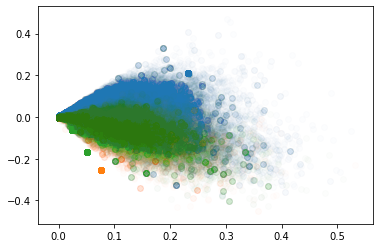

In [127]:
for i in range(n_topics):
    indices = np.argwhere(topics_assigned == i)
    plt.scatter(svd_transformed[indices,0], svd_transformed[indices,1], alpha = 0.01)

Review of documents

In [128]:
topic = 0; n = 10; np.random.seed(3)
indices = np.argwhere((topics_assigned == topic) & 
                      (np.sum(nmf_transformed == 0, axis=1) == 2) # focus only on those where there's no topic mix
                     ).T[0]
indices_selected = np.random.choice(indices, n)

for sentence in sentence_list_pd.iloc[indices_selected]['sentence']:
    print(sentence)
    print()

sign up for our weekly newsletter.

loading... five people are in a conference room, surrounded by hundreds of empty, plastic -ounce bottles.

in a statement released thursday night, the public defender's office expressed disappointment but said the office would continue to work with the da's office to secure the release of individual inmates.

peter thorne, a spokesman for the city department of correction, said in a statement that the city âis doing everything we can to safely and humanely house people in our custodyâ during the epidemic.

even before the supreme courtâs emergency order, khandelwal said dpd had been asking for all out-of-custody hearings to be postponed until at least april .

do you think having, like, parents who were in prison, guardians who raised you who were radical leftists who lived underground for a while, then having a grandfather who was a civil liberties lawyer - do you think that whole constellation of family is what motivated you to dedicate your 

### Subtopic Analytics: NMF

In [115]:
indices_bigtopic = np.argwhere(topics_assigned == 0).T[0]
preprocessed_text_bigtopic = [txt for e, txt in enumerate(preprocessed_text) if e in indices_bigtopic]

In [116]:
t = time.time()
w2v_model_topicX = gensim.models.Word2Vec(
    preprocessed_text_bigtopic,
    size=500, min_count=preprocessor.dictionary_no_below_, sg=1)
print(time.time() - t)

In [117]:
topic_models = []
for n_topics in range(2, 10):
    t = time.time()
    nmf = NMF(n_components=n_topics, random_state=20)
    nmf_transformed = nmf.fit_transform(tfidf_sparse[indices_bigtopic])
    topic_models.append([n_topics, nmf_transformed, nmf.components_])
    print('n topics: ' + str(n_topics))
    print(time.time() - t)

n topics: 2
7.809162616729736
n topics: 3
8.05700969696045
n topics: 4
9.467156171798706
n topics: 5
15.22657036781311
n topics: 6
15.267542839050293
n topics: 7
10.12273120880127
n topics: 8
13.403700590133667
n topics: 9
14.61994743347168


In [118]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top n terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 100 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model_topicX, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

C:\Users\vldoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


K=02: Coherence=0.2373
K=03: Coherence=0.2358
K=04: Coherence=0.2387
K=05: Coherence=0.2409
K=06: Coherence=0.2422
K=07: Coherence=0.2458
K=08: Coherence=0.2559
K=09: Coherence=0.2592


In [119]:
nmf = NMF(n_components=9, random_state=20)
nmf_transformed = nmf.fit_transform(tfidf_sparse[indices_bigtopic])
topics_assigned = np.argmax(nmf_transformed, axis=1)
print_top_words_nmf(nmf, dictionary, n_top_words=20)

Topic #0: prison state feder coronavirus spread offici outbreak virus bureau feder_bureau covid popul year york visit countri father advoc risk pandem

Topic #1: test_posit covid staff_member virus employe accord die coronavirus april hospit detaine staffer announc offici monday total addit resid friday sunday

Topic #2: say go offici week time statement know need like work come right want think theyâ take thing communiti continu place

Topic #3: jail counti popul reduc spread sheriff coronavirus hold offic outbreak detaine march cook_counti francisco covid effort go insid countri take

Topic #4: peopl incarcer know communiti die million like hold need right virus risk hospit time come recov moder_symptom sick live caus_mild

Topic #5: releas order earli court sentenc judg detaine month week pandem day consid march year serv call risk plan ask coronavirus

Topic #6: correct depart facil offic health work state employe staff care accord provid offici covid protect center medic servic vi

In [121]:
truncatedsvd = TruncatedSVD(n_components = 30, algorithm = 'randomized', random_state = 20)
svd_transformed = truncatedsvd.fit_transform(tfidf_sparse[indices_bigtopic])

for i in range(n_topics):
    indices = np.argwhere(topics_assigned == i)
    plt.scatter(svd_transformed[indices,0], svd_transformed[indices,1], alpha = 0.1)

MemoryError: Unable to allocate 64.1 MiB for an array with shape (40, 209882) and data type float64

Semi-supervised modeling
* https://medium.com/pew-research-center-decoded/overcoming-the-limitations-of-topic-models-with-a-semi-supervised-approach-b947374e0455

NMF notes:
* https://github.com/derekgreene/topic-model-tutorial

## CoRex

In [11]:
from scipy.sparse import csr_matrix, find
from scipy import sparse

def sparse_where(mask, val, arr):
    """ Sparse `np where` """
    out = arr.copy()
    rows, cols, _ = find(mask)
    for r, c in zip(rows, cols):
        out[r, c] = val
    return out

# # Create binary matrix
# matrix = sparse.csr_matrix(np.array([0, 1, 0, 1]))
# x_s, y_s, t_fs = find(matrix > 0)
# sparse_where(matrix > 0, 66, x).todense()

t = time.time()
dtm_binary_sparse = sparse_where(tfidf_sparse > 0, 1, tfidf_sparse)
print(time.time() - t)

# Get word list
words = [dictionary[e] for e in range(len(dictionary))]

234.19367098808289


In [50]:
dictionary.token2id

{'antonio_texa': 0,
 'arrest': 1,
 'expos': 2,
 'hold': 3,
 'inmat': 4,
 'jail': 5,
 'novel_coronavirus': 6,
 'offic': 7,
 'possibl': 8,
 'prior': 9,
 'quarantin': 10,
 'tell': 11,
 'texa': 12,
 'experi_flulik': 13,
 'isol': 14,
 'offici': 15,
 'prompt': 16,
 'report': 17,
 'symptom': 18,
 'unnam': 19,
 'come_contact': 20,
 'contractor_antonio': 21,
 'express': 22,
 'news': 23,
 'peopl': 24,
 'recent': 25,
 'virus': 26,
 'work': 27,
 'accord': 28,
 'antonio': 29,
 'coronavirus': 30,
 'counti': 31,
 'hear': 32,
 'home': 33,
 'outlet': 34,
 'pretti_unrealist': 35,
 'relat': 36,
 'resid': 37,
 'salazar_bexar': 38,
 'say': 39,
 'scenario_actual': 40,
 'self_quarantin': 41,
 'sheriff_javier': 42,
 'sheriffâ_offic': 43,
 'act': 44,
 'add': 45,
 'appropri': 46,
 'claim': 47,
 'want_sure': 48,
 'bexar_counti': 49,
 'come': 50,
 'determin': 51,
 'evalu': 52,
 'like': 53,
 'medic_profession': 54,
 'sicken_cold': 55,
 'antonio_express': 56,
 'assault_dead': 57,
 'cell': 58,
 'charg_aggrav': 59,
 

## v1: Unseeded

In [75]:
from corextopic import corextopic as ct


C:\Users\vldoa\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [82]:
t = time.time()

# Train the CorEx topic model
topic_model = ct.Corex(n_hidden=2)  # Define the number of latent (hidden) topics to use.
topic_model.fit(dtm_binary_sparse, words=words)

print(time.time() - t)

319.62107157707214


In [84]:
topic_model.get_topics(20)

[[('inmat', 0.08586505199443932),
  ('prison', 0.05559236571260335),
  ('covid', 0.04693015666031037),
  ('correct', 0.039162652333908525),
  ('facil', 0.03606587441134607),
  ('depart', 0.03596304401868144),
  ('state', 0.035928341841552816),
  ('jail', 0.03355230810846108),
  ('releas', 0.03289581929458154),
  ('offici', 0.02780484915712747),
  ('test_posit', 0.027257697384006612),
  ('say', 0.026290996256156298),
  ('coronavirus', 0.024815873950158548),
  ('health', 0.022803559291557654),
  ('counti', 0.021248337405688062),
  ('virus', 0.020452722761421595),
  ('staff', 0.018478389432892244),
  ('spread', 0.017569663484044633),
  ('case', 0.016201347647915903),
  ('offic', 0.01587731698980752)],
 [('court', 0.024233508205563265),
  ('judg', 0.014978865998597),
  ('sentenc', 0.0131830695008204),
  ('attorney', 0.011086063916750566),
  ('charg', 0.01083320805713821),
  ('order', 0.007377010293519846),
  ('american_civil', 0.007318833012455026),
  ('liberti_union', 0.007214251190929708

In [94]:
t = 1

ids = topic_model.get_top_docs(5)[t]
ids = np.array([_[0] for _ in ids])

for s in sentence_list_pd.iloc[ids]['sentence']:
    print(s)
    print()

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
delaware enters âacceleration phaseâ of virus spread the number of coronavirus cases in delaware is more than doubling every three days, with a % increase in cases over the past week.

pratt on monday noted that sheriff tom ferrara, in a letter to county officials on friday, cited a march order from solano county superior court officials authorizing the release of inmates who are serving county jail commitments with days or less remaining on their sentence, âso long as they qualify within the criteria set forth in the order.â however, no inmate whose crime includes serving time for domestic violence or an offense involving a victim of domestic violence or serving time for an offense that requiresregistration as a sex offender is eligible for early release, noted ferrara.

"there are over , people incarcerated in arizona and the environment of prisons are fertile for an outbreak â closed quarters, l

# v2: Seeded

In [140]:
tfidf_sparse[:,[dictionary.token2id['spread']]]

<262741x1 sparse matrix of type '<class 'numpy.float64'>'
	with 7540 stored elements in Compressed Sparse Row format>

In [145]:
t = time.time()

# Train the CorEx topic model
topic_model = ct.Corex(n_hidden=4)  # Define the number of latent (hidden) topics to use.
topic_model.fit(dtm_binary_sparse, words=words, anchor_strength=2)

print(time.time() - t)

In [141]:
t = time.time()

# Train the CorEx topic model
topic_model_anchored = ct.Corex(n_hidden=4)  # Define the number of latent (hidden) topics to use.
topic_model_anchored.fit(dtm_binary_sparse, words=words,
                         anchors=[['crimin', 'violent'],
                                  ['crimin', 'violent'],
                                  ['health', 'spread'],
                                  ['health', 'spread']
                                 ], anchor_strength=3)

print(time.time() - t)

411.2253496646881


In [144]:
# f = open('big-data/modelling-sentences/topic-model.pkl', "wb") # remember to open the file in binary mode
# pickle.dump(topic_model, f)
# f.close()

# f = open('big-data/modelling-sentences/topic-model-anchored.pkl', "wb") # remember to open the file in binary mode
# pickle.dump(topic_model_anchored, f)
# f.close()

In [142]:
topic_model_anchored.get_topics(20)

[[('crimin', 0.019624293939131388),
  ('violent', 0.010845302051989662),
  ('sentenc', 0.01945407735828215),
  ('charg', 0.012574493522986016),
  ('attorney_general', 0.008297124944715925),
  ('convict', 0.0064284777448359405),
  ('trump', 0.006235679139902886),
  ('serv', 0.005911808763046744),
  ('william_barr', 0.005820749586017451),
  ('year', 0.00554649121043561),
  ('crime', 0.0052635933160339),
  ('home_confin', 0.004955723775521641),
  ('arrest', 0.00465582322016501),
  ('serv_year', 0.004168177524973875),
  ('presid_donald', 0.003917442627377313),
  ('month', 0.0035366034772879537),
  ('murder', 0.0034681180948658882),
  ('face', 0.0031563205128892235),
  ('second_degre', 0.0031153030281095024),
  ('violat', 0.00309888127570372)],
 [('releas', 0.09550727529771513),
  ('court', 0.043814777624183184),
  ('crimin', 0.014174595891422241),
  ('judg', 0.029872315917768472),
  ('violent', 0.007849220693117722),
  ('order', 0.018056870289397658),
  ('attorney', 0.016862015266518943),


In [151]:
t = 2

ids = topic_model_anchored.get_top_docs(10)[t]
ids = np.array([_[0] for _ in ids])

for s in sentence_list_pd.iloc[ids]['sentence']:
    print(s)
    print()

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
related: why health experts aren't warning about coronavirus in food related: healthy-looking people spread coronavirus, more studies say related: census day arrives with us almost paralyzed by coronavirus

âsheriffâs office staff and jail health services have worked in overdrive to minimize contact among the people in our jails.â the case comes as the city scrambles to reduce its jail population to prepare for an outbreak of incarcerated people in close quarters.

christopher blackwell, an inmate at the washington state facility, wrote an article for buzzfeed this week detailing the lack of cleaning supplies and precautions at the prison and the concern growing among its wards.

the group argued that continuing to hold the inmates in conditions that pose such serious health risks is unconstitutional.

âthe urgency of deliberate and thoughtful action cannot be overstated.â the new york legal aid so

## v3: Seeded, plus unseeded topics

In [153]:
t = time.time()

# Train the CorEx topic model
topic_model_anchored2 = ct.Corex(n_hidden=6)  # Define the number of latent (hidden) topics to use.
topic_model_anchored2.fit(dtm_binary_sparse, words=words,
                         anchors=[['crimin', 'violent'],
                                  ['crimin', 'violent'],
                                  ['health', 'spread'],
                                  ['health', 'spread'],
                                  [],
                                  []
                                 ], anchor_strength=3)

print(time.time() - t)

451.5074026584625


In [154]:
topic_model_anchored2.get_topics(20)

[[('crimin', 0.018774760587748577),
  ('violent', 0.010379847922646155),
  ('sentenc', 0.02626913679717099),
  ('court', 0.02198260119984864),
  ('charg', 0.016111753094707856),
  ('arrest', 0.011025306552636482),
  ('serv', 0.009087457802515965),
  ('convict', 0.008989692888954853),
  ('attorney', 0.008250673162374525),
  ('bail', 0.008244199178531097),
  ('offic', 0.007630610927890992),
  ('trial', 0.0067309698458657185),
  ('crime', 0.006563322919689976),
  ('defend', 0.006156386810960777),
  ('year', 0.005978659959066944),
  ('misdemeanor', 0.00506865808753089),
  ('polic', 0.004944850434059805),
  ('hear', 0.004785016391410805),
  ('public_defend', 0.004585532531544158),
  ('violat', 0.004436090248741327)],
 [('releas', 0.09622922526112346),
  ('crimin', 0.01471124123197177),
  ('violent', 0.008145157511056092),
  ('judg', 0.021792500859524954),
  ('order', 0.017492613958969627),
  ('feder', 0.012059078852200806),
  ('earli', 0.01180748506773187),
  ('attorney_general', 0.01127705

In [164]:
t = 3

ids = topic_model_anchored2.get_top_docs(10)[t]
ids = np.array([_[0] for _ in ids])

for s in sentence_list_pd.iloc[ids]['sentence']:
    print(s)
    print()

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices
related: why health experts aren't warning about coronavirus in food related: healthy-looking people spread coronavirus, more studies say related: census day arrives with us almost paralyzed by coronavirus

but the family would not be able to attend the burial because gatherings put people at increased risk of contracting or spreading the virus.

the department of corrections and the department of health have not provided a tally of inmates who have been tested.

saint said the facility passed a county health inspection on march with no significant issues noted.

âall of our facilities are actively promoting the following three health habits for inmates, detainees and residents, as well as staff: regular hand hygiene, respiratory etiquette (coughing or sneezing into a sleeve or tissue), and avoiding touching oneâs face,â corecivic said.

it said it works with local and state health departments to condu

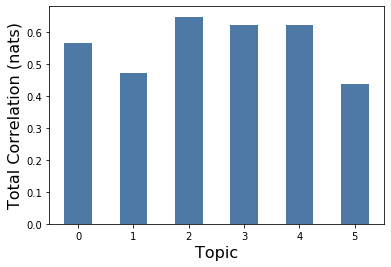

In [160]:
plt.bar(range(topic_model_anchored2.tcs.shape[0]), topic_model_anchored2.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

# v4: informed seeding

In [73]:
find_sum('nonviol_offens')
find_sum('nonviol_offend')
find_sum('nonviol_feloni')
find_sum('nonviol_crime')
find_sum('nonviol')
find_sum('nonviol_misdemeanor')
###
find_sum('violent')
find_sum('violent_offens')
find_sum('violent_offend')
find_sum('violent_crime')

term: nonviol_offens, 140.0
term: nonviol_offend, 339.0
term: nonviol_feloni, 16.0
term: nonviol_crime, 114.0
term: nonviol, 627.0
term: nonviol_misdemeanor, 21.0
term: violent, 793.0
term: violent_offens, 180.0
term: violent_offend, 406.0
term: violent_crime, 302.0


In [74]:
t = time.time()
# Train the CorEx topic model
topic_model_anchored4 = ct.Corex(n_hidden=6)  # Define the number of latent (hidden) topics to use.
topic_model_anchored4.fit(dtm_binary_sparse, words=words,
                         anchors=[['nonviol_offens', 'nonviol_offend', 'nonviol_feloni', 'nonviol_crime',
                                   'nonviol', 'nonviol_misdemeanor'],
                                  ['violent', 'violent_offens', 'violent_offend', 'violent_crime'],
                                  [],
                                  [],
                                  []
                                 ], anchor_strength=3)

print(time.time() - t)

NameError: name 'ct' is not defined